In [2]:
from fastai.vision.all import *
import fastai
import timm
import albumentations as A

# In[2]:


import torch
torch.cuda.set_device(1)

In [2]:
import os
def create_csvValid(path):
    output_path = os.path.join(path,"..","df_multilabel_train.csv")
    if (os.path.exists(output_path)):
        output_path_csv = open(output_path, "a")
    else:
        output_path_csv = open(output_path, "w")
        head = "images, class\n"
        output_path_csv.write(head)

    
    lista_archivos = list(os.walk(path))
    lista_archivos.sort()
    for carpeta in lista_archivos:
#         print(carpeta[0])
        video = carpeta[0].split(os.path.sep)[-1]
        for files in carpeta[2]:
            if "images_labelSmoothing.csv" in files:
                leer = open(os.path.join(carpeta[0],files))
                leer.readline()
                for l in leer:
                    escribir = ""
                    l = l.split(",")
                    for clas in l[1:]:
                        if float(clas)>0:
                            escribir= escribir +str(l.index(clas)-1) +" "
                    escribir = escribir[:-1]
                    if len(escribir)==0:
                        escribir = escribir+ "0"
                    escribir = escribir + "\n"
                    output_path_csv.write(video+os.path.sep+"images"+os.path.sep+l[0]+","+escribir)
#                     print(l)
                

In [2]:
create_csvValid("./dataset_split_77frames/train")

In [3]:
import pandas as pd
import numpy as np

dfValid = pd.read_csv('./dataset_split_77frames/df_multilabel_train.csv')

dfTest = pd.read_csv('./dataset_split_77frames/df_multilabel_test.csv')


# In[5]:


# prueba = dfValid


# prueba = prueba.iloc[np.random.permutation(len(prueba))]
# prueba = prueba[0:int(len(prueba)*0.1)]
# # In[6]:
# # Aquí debería hacer dos df diferentes. Uno para entrenamiento y otro para validación. En este caso 
# # usa para entrenar el set de entrenamiento y validación. Imagino que la división la hará por programa
# # dfValid = dfValid[(dfValid.set == 'training') | (dfValid.set == 'validation')]




# # Hay que modificar esto para que haya set de validación. Hacer un vector random y que esté entre las primeras 
# # 0.1 posiciones si está se devuelve 
# def is_valid(path):
#     name = path[0]
# #     return (dfValid[dfValid['challenge_id']==name])['set'].values[0]=='validation'
#     return (dfValid[dfValid['images']==name]).values[0] in prueba.images.values
    
# # In[13]:

# def get_class(path):
#     name = path[0]
#     return (dfValid[dfValid['images']==name])['class']


In [11]:
dfValid.head()

,images,class
0,IDU001V001/images/IDU001V001_from_0_to_77,0 1
1,IDU001V001/images/IDU001V001_from_57_to_134,1
2,IDU001V001/images/IDU001V001_from_114_to_191,1 2
3,IDU001V001/images/IDU001V001_from_171_to_248,2
4,IDU001V001/images/IDU001V001_from_228_to_305,2


In [4]:
def get_dls(presize=100,size=77,M=0,bs=6):
    db = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
             splitter=RandomSplitter(),
             get_x = ColReader(0,pref="./dataset_split_77frames/train/",suff='.jpg'),
             get_y=ColReader(1,label_delim=' '),
             item_tfms = [Resize(presize)], # CropPad(200,200)
             batch_tfms=[*aug_transforms(size=size, min_scale=0.75,do_flip=False,flip_vert=False,
                  max_rotate=0.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                         Normalize.from_stats(*imagenet_stats)])
    dls = db.dataloaders(dfValid.values,bs=bs)
    return dls

In [5]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='resnetrsRandAugLS',monitor='cohen_kappa_score'),
    ReduceLROnPlateau(patience=10)
]

In [6]:
dlsTrain3 = get_dls()

learn = Learner(dlsTrain3,timm.create_model('resnetrs50',num_classes=13,pretrained=True),
                metrics=[accuracy,CohenKappa(weights='quadratic')],cbs=callbacks).to_fp16()

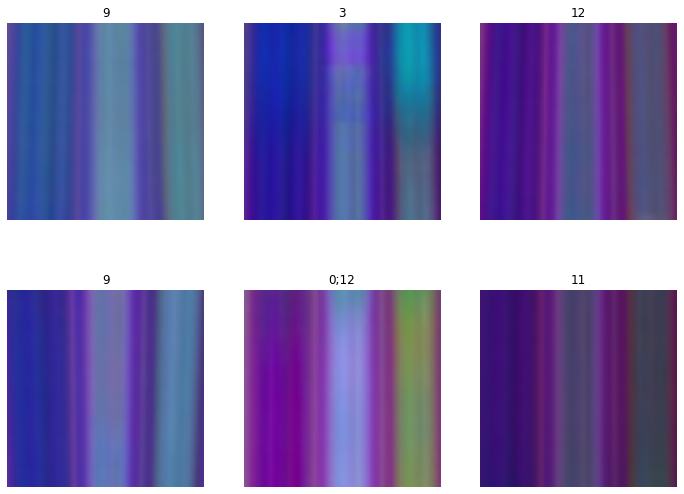

In [7]:
dlsTrain3.show_batch(max_n=100, figsize=(12,9))

In [7]:
learn = cnn_learner(dlsTrain3, resnet34, pretrained=True, metrics=[accuracy_multi])

In [8]:
class BCEWithLogitsLossFlat(BaseLoss):
    "Same as `nn.BCEWithLogitsLoss`, but flattens input and target."
    @use_kwargs_dict(keep=True, weight=None, reduction='mean', pos_weight=None)
    def __init__(self, *args, axis=-1, floatify=True, thresh=0.5, **kwargs):
        if kwargs.get('pos_weight', None) is not None and kwargs.get('flatten', None) is True:
            raise ValueError("`flatten` must be False when using `pos_weight` to avoid a RuntimeError due to shape mismatch")
        if kwargs.get('pos_weight', None) is not None: kwargs['flatten'] = False
        super().__init__(nn.BCEWithLogitsLoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)
        self.thresh = thresh

    def decodes(self, x):    return x>self.thresh
    def activation(self, x): return torch.sigmoid(x)

In [9]:
learn.loss_func = BCEWithLogitsLossFlat()

SuggestedLRs(valley=0.007585775572806597)

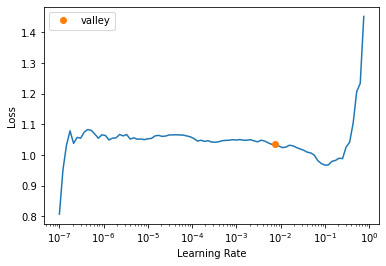

In [10]:
learn.lr_find()

In [11]:
learn.fine_tune(50,base_lr=3e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.328118,0.277131,0.897221,01:02


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.263083,0.199390,0.919931,01:14
1,0.220345,0.181389,0.925748,01:14
2,0.215180,0.165066,0.930919,01:15
3,0.205416,0.163720,0.932859,01:15
4,0.194362,0.165051,0.932557,01:13
5,0.210659,0.160018,0.935057,01:15
6,0.190562,0.157779,0.931954,01:14
7,0.192500,0.148824,0.940789,01:14
8,0.186333,0.145646,0.938289,01:14
9,0.173919,0.140758,0.942598,01:12


In [12]:
learn.save("resnetrsRandAugLS_77frames_multilabel")

Path('models/resnetrsRandAugLS_77frames_multilabel.pth')

In [8]:
dbTest = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                 get_x = ColReader(0,pref="./dataset_split_77frames/test/",suff='.jpg'),
                 get_y=ColReader(1,label_delim=' '),
                 item_tfms = Resize(100),
                 batch_tfms=[*aug_transforms(size=77, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(dfTest.values,bs=128)


In [29]:
learn.dls = dlsTest
learn.validate()

# interp = ClassificationInterpretation.from_learner(learn)
# interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

(#2) [0.15308748185634613,0.9479076862335205]

In [18]:
predictions, truth =learn.get_preds()

pred2= []
treshold = 0.5
for predi in predictions:
    adc = []
    for p in predi:
        if p < treshold:
            adc.append(int(0))
        else: adc.append(int(1))
    pred2.append(adc)


In [30]:
print(pred2[5])
print(predictions[5])
print(truth[5])

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
tensor([2.0232e-05, 1.5069e-02, 2.8162e-03, 9.0271e-04, 3.6845e-04, 9.8449e-01,
        2.8433e-02, 4.6216e-04, 1.2993e-03, 5.1720e-03, 2.7705e-03, 3.7722e-04,
        5.2317e-04])
TensorMultiCategory([0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.])


In [24]:
from sklearn.metrics import multilabel_confusion_matrix
vis_arr = multilabel_confusion_matrix(truth, pred2)

In [31]:
vis_arr

array([[[411,   2],
        [  9,  21]],

       [[419,   0],
        [ 10,  14]],

       [[376,   9],
        [ 25,  33]],

       [[356,  12],
        [ 44,  31]],

       [[357,  22],
        [ 28,  36]],

       [[398,   3],
        [ 14,  28]],

       [[395,   1],
        [ 13,  34]],

       [[406,   7],
        [  9,  21]],

       [[413,  10],
        [  9,  11]],

       [[417,   2],
        [  9,  15]],

       [[423,   0],
        [  9,  11]],

       [[400,   5],
        [ 18,  20]],

       [[297,  11],
        [ 19, 116]]])

In [26]:
labels = ["".join("c" + str(i)) for i in range(0, 13)]


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

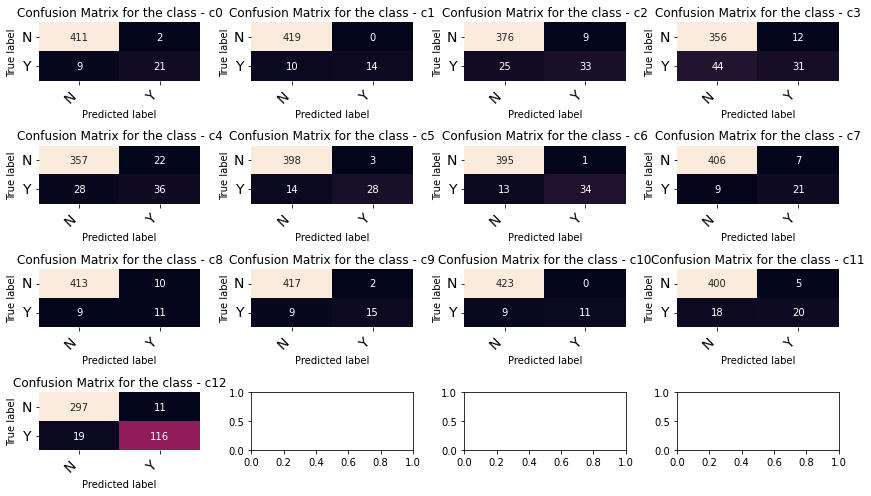

In [28]:
fig, ax = plt.subplots(4, 4, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()

In [10]:
dls2 = get_dls()
learn2 = Learner(dls2,timm.create_model('resnetrs50',num_classes=13,pretrained=True),
                metrics=[accuracy,CohenKappa(weights='quadratic')],cbs=callbacks).to_fp16()

In [11]:
learn2 = cnn_learner(dlsTrain3, resnet34, pretrained=True, metrics=[accuracy_multi])

In [12]:
learn2.loss_func = BCEWithLogitsLossFlat()

In [13]:
learn2.load("resnetrsRandAugLS_77frames_multilabel")

In [14]:
learn2.validate()

(#2) [0.05403352528810501,0.98000568151474]

In [15]:
predictions, truth =learn2.get_preds()

pred2= []
treshold = 0.5
for predi in predictions:
    adc = []
    for p in predi:
        if p < treshold:
            adc.append(int(0))
        else: adc.append(int(1))
    pred2.append(adc)


In [16]:
max_preds = np.argmax(pred2,axis = 1)

In [17]:
max_preds

array([ 2, 11, 12, ..., 12,  6,  5])

In [18]:
from sklearn.metrics import accuracy_score
accuracy_score(truth,pred2)

0.7820728291316527

In [35]:
path_vid = './dataset_split_77frames/test/IDU027V002_20220209_163603'
imgs = []
probs = []
classes_pred = []
for _, line in dfTest.iterrows():
#     print(line[0])
    if "IDU002V001" in line[0]:
        imgs.append(line[0])
# print(imgs)

for img in imgs:
    img = img + '.jpg'
    predic_class,_,probs1 = learn2.predict('./dataset_split_77frames/test/'+img)
    frame = [0]*13
    for c in predic_class:
        frame[int(c)]+=1
    classes_pred.append(frame)
    probs.append(probs1)

In [36]:
classes_pred

[[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

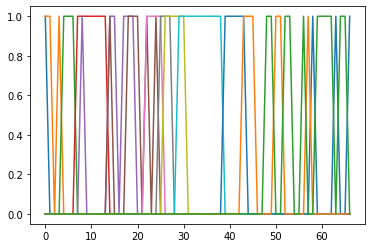

In [40]:
from matplotlib.pyplot import plot
plot(range(0,len(classes_pred)),[x for x in classes_pred])

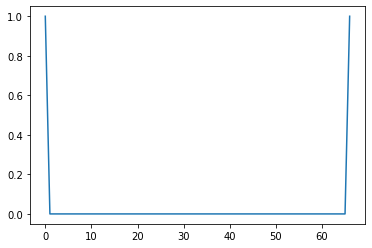

In [41]:
plot(range(0,len(classes_pred)),[x[0] for x in classes_pred])

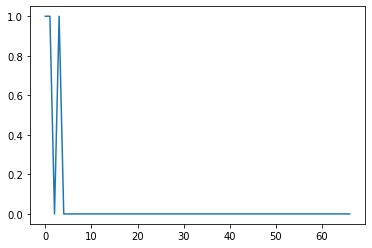

In [54]:
plot(range(0,len(classes_pred)),[x[1] for x in classes_pred])

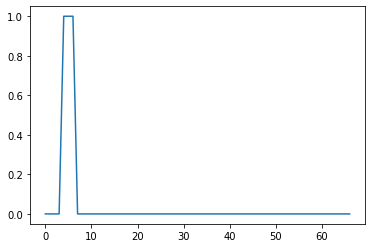

In [55]:
plot(range(0,len(classes_pred)),[x[2] for x in classes_pred])

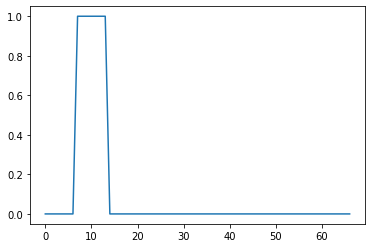

In [56]:
plot(range(0,len(classes_pred)),[x[3] for x in classes_pred])

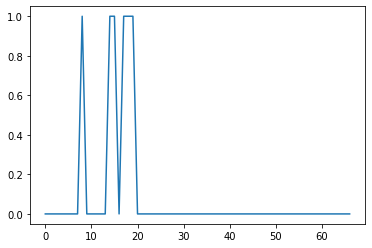

In [57]:
plot(range(0,len(classes_pred)),[x[4] for x in classes_pred])

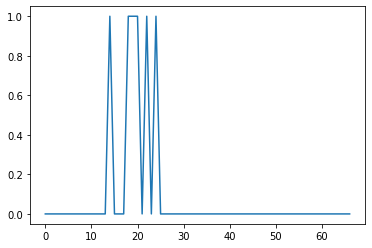

In [58]:
plot(range(0,len(classes_pred)),[x[5] for x in classes_pred])

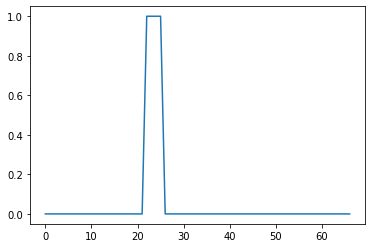

In [59]:
plot(range(0,len(classes_pred)),[x[6] for x in classes_pred])

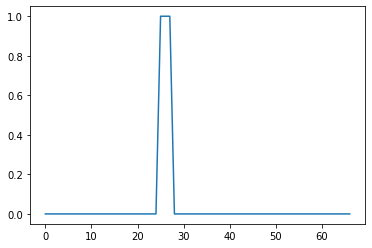

In [60]:
plot(range(0,len(classes_pred)),[x[7] for x in classes_pred])

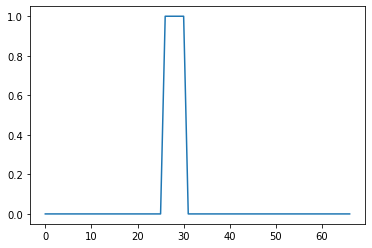

In [61]:
plot(range(0,len(classes_pred)),[x[8] for x in classes_pred])

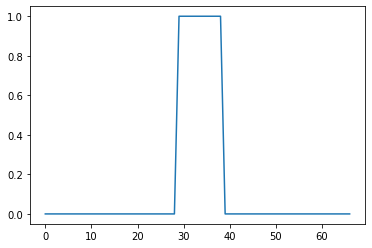

In [62]:
plot(range(0,len(classes_pred)),[x[9] for x in classes_pred])

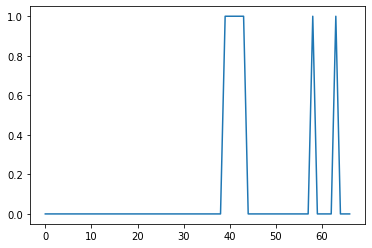

In [63]:
plot(range(0,len(classes_pred)),[x[10] for x in classes_pred])

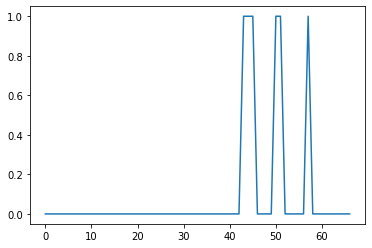

In [64]:
plot(range(0,len(classes_pred)),[x[11] for x in classes_pred])

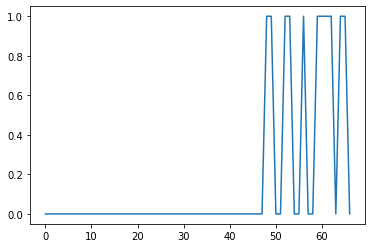

In [65]:
plot(range(0,len(classes_pred)),[x[12] for x in classes_pred])